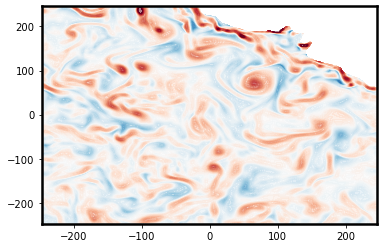

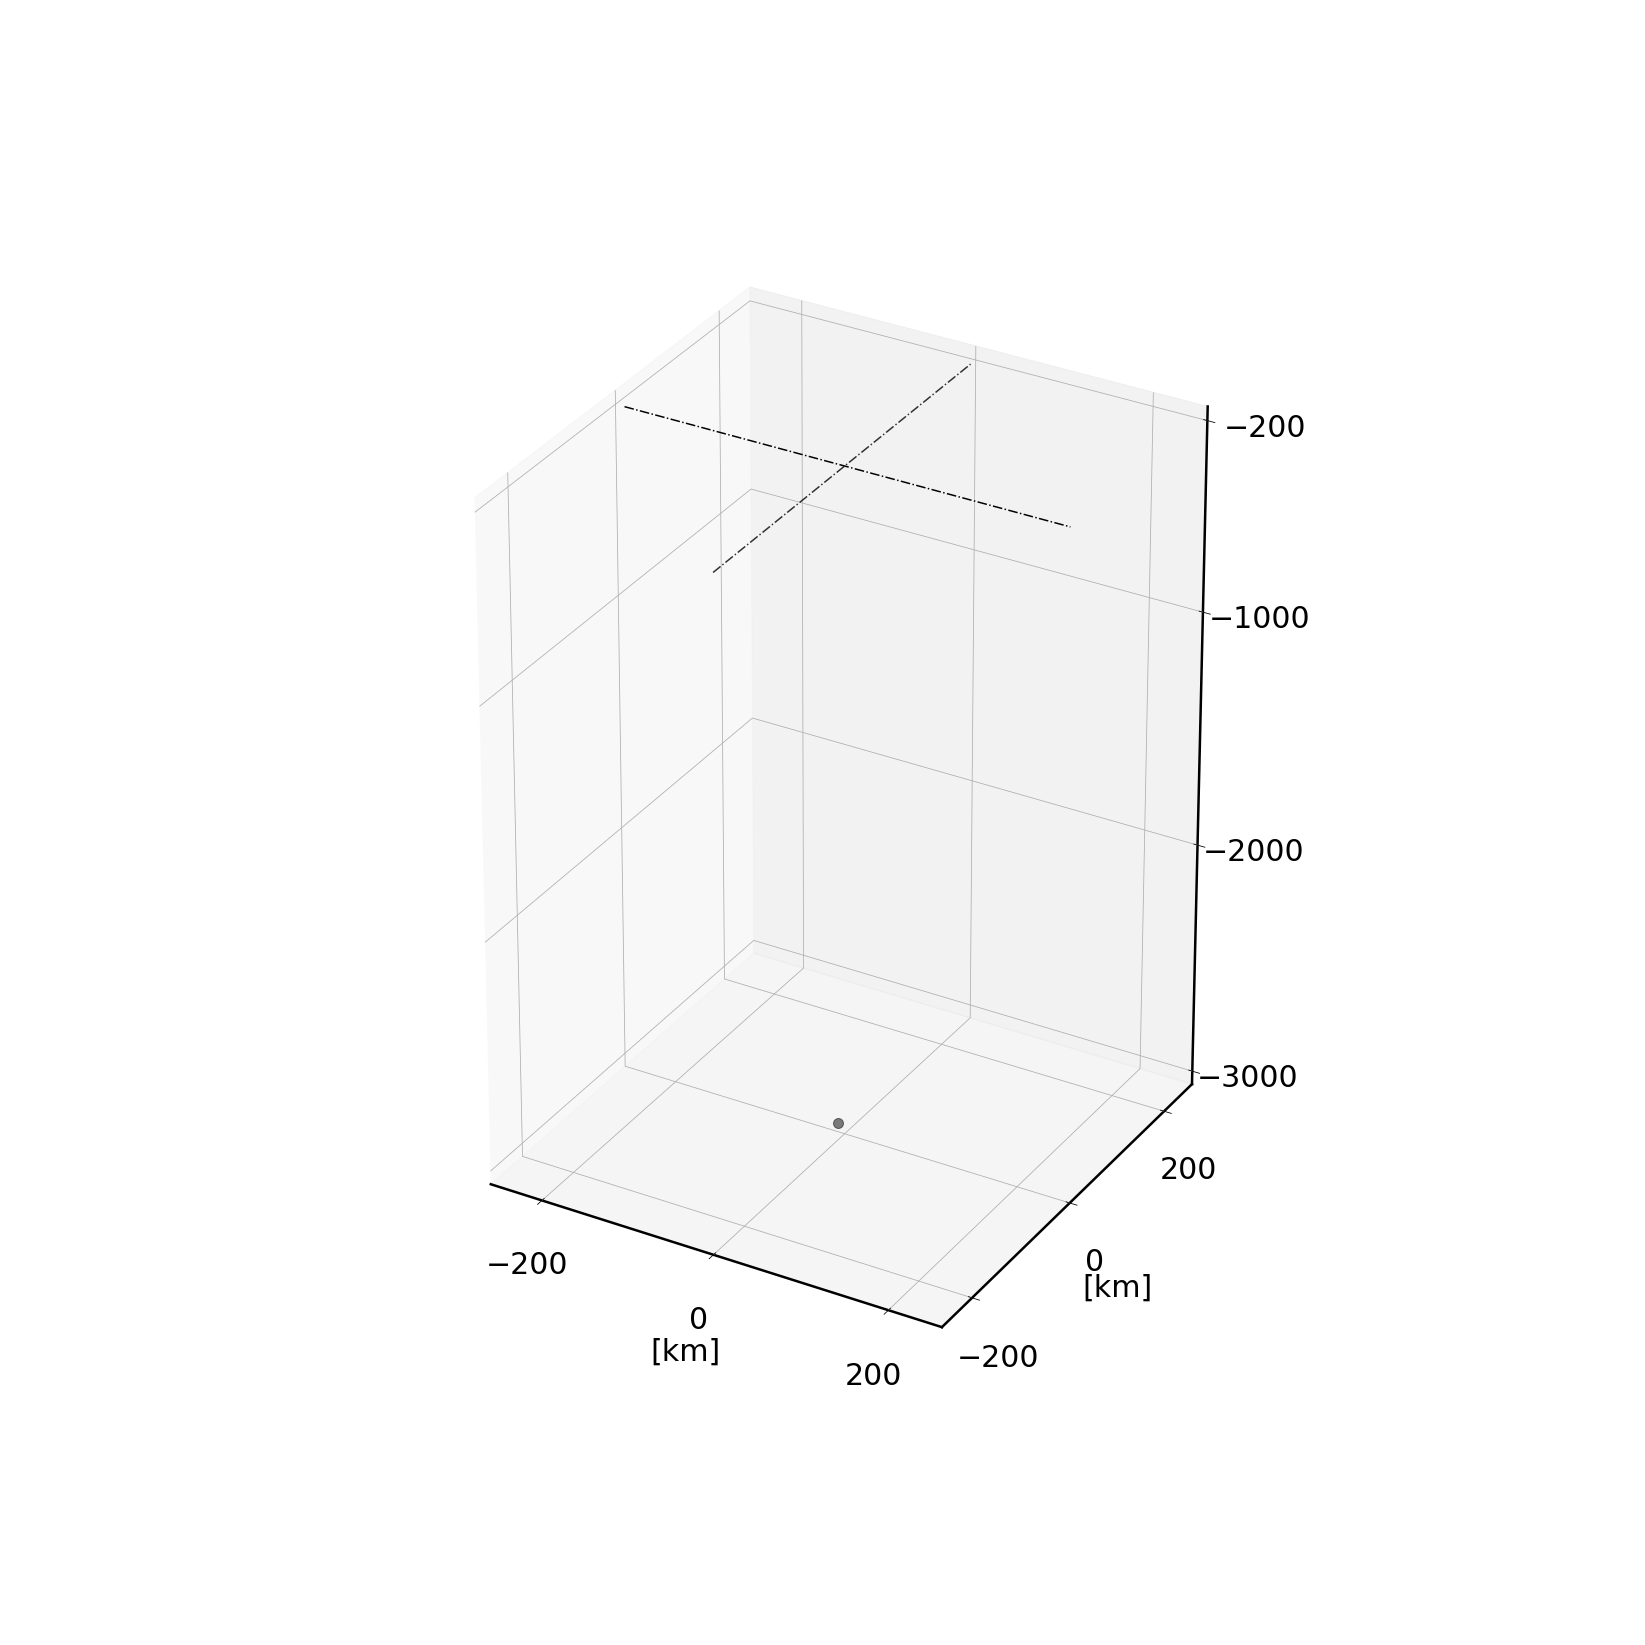

In [1]:
def plot_background_level_u_v_w(ic,jc,t,list_level):

    dx, dy = 1.979, 1.979 #grid size
    my_simul = 'apero'
    str_para = ' [{0},{1},{2},{3},[1,100,1]] '.format(jc-125,jc+125,ic-125,ic+125)
    parameters = my_simul +str_para+ format(t)
    simul = load(simul = parameters, floattype=np.float64,output=False)

    depths = -np.array(list_level)
    
    temp = var('temp',simul,depths=depths).data
    ssh = var('zeta',simul).data
    u = var('u',simul,depths=depths).data
    v = var('v',simul,depths=depths).data
    w = var('w',simul,depths=depths).data
    
    u = tools.u2rho(u)
    v = tools.v2rho(v)
    
    return (u,v,w)

from netCDF4 import Dataset
import numpy as np
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import sys
sys.path.append("../")
from plot_function import *
from variables_create_data import *

labelsize = 30
labelpad = 40 + 30
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.50

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from IPython.display import clear_output
import matplotlib.cm as cm

from mpl_toolkits.mplot3d.axes3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

"""                                                                                                                                                    
Scaling is done from here...                                                                                                                           
"""
x_scale=2
y_scale=2
z_scale=4

scale=np.diag([x_scale, y_scale, z_scale, 1.0])
scale=scale*(1.0/scale.max())
scale[3,3]=1.0

def short_proj():
    return np.dot(Axes3D.get_proj(ax), scale)

    
%matplotlib inline 

### LOADING PARTICLES DATA ###
#folder = '/home2/scratch/tpicard/Pyticles/outputs/'
folder = "/home/datawork-lemar-apero/tpicard/PYTICLE/"
tend = 1370
t0 = tend-120

file = folder + 'apero_trap3000m_wsed100_2000dx_100nx_00{0}_00{1}.nc'.format(t0,tend) #AC?
number_of_exp = 0

#List of the 36 sub-patches centers 
ic_all_list = np.linspace(1520.5,1610.5,6)
jc_all_list = np.linspace(569.5,659.5,6)
i_ic = 3
i_jc = 3

nc = Dataset(file, 'r')
part_x = nc.variables['px'][:,:]
part_y = nc.variables['py'][:,:]
pdepth = nc.variables['pdepth'][:,:] #(dt,nb_particle)

[ic,jc] = [ic_all_list[i_ic],  jc_all_list[i_jc]]

#[ic,jc] = np.load('/home2/datahome/tpicard/Pyticles/Inputs/ic_jc.npy')

index_part = spatial_filter(part_x,part_y,ic,jc,number_of_exp) #Filtre spatial #0, 20 ou 40

part_x = part_x[:,index_part]
part_y = part_y[:,index_part]
pdepth = pdepth[:,index_part] #(dt,nb_particle)

dx, dy = 1.979, 1.979 #grid size
npart_trap = pdepth.shape[1]

x_disp = []
y_disp = []
time = []

#list_level = [2500,2000,1500,1000,200]
list_level = [3000,2000,1000,200]
#list_level = [2500,1700,1000,200]
x_disp_level = np.zeros((len(list_level),720))
y_disp_level = np.zeros((len(list_level),720))

l = 0
for level in list_level:
    x_disp =[]
    y_disp=[]
    for ipart in range(npart_trap):

        index_realtime = np.where( pdepth[:,ipart] != 0 )[0] # find the period when particles are released

        if index_realtime.size != 0:# check if particles are released
            pdepth_tmp = pdepth[index_realtime,ipart]
            index_200m = np.argmax(pdepth_tmp > -level)


            if index_200m != 0: # particles have reached upper -200 m            
                index_200m = np.round(index_realtime[index_200m])
                x_disp.append( (part_x[index_200m, ipart]-ic )*dx ) #difference pour avoir un schéma centré
                y_disp.append( (part_y[index_200m, ipart]-jc)*dy )
                time.append(index_200m)

    if len(x_disp)!=720:
        for p in range(len(x_disp),720):
            x_disp.append(x_disp[p-1])
            y_disp.append(y_disp[p-1])

    x_disp_level[l,:]=np.array(x_disp)
    y_disp_level[l,:]=np.array(y_disp)
    l=l+1


levels_vrt=np.linspace(-0.2,0.2,100)
vrt = np.zeros((250,250,len(list_level)))

(lon,lat,vrt) = plot_background_level(int(ic),int(jc),tend,list_level)
(u,v,w) = plot_background_level_u_v_w(int(ic),int(jc),tend,list_level)

topo = get_topo(int(ic),int(jc),tend,list_level)

cf = plt.contourf(lon, lat, vrt[:,:,-0],
        zdir='z', offset=-list_level[0],cmap = plt.cm.RdBu_r,alpha = 0.5,vmin=-0.2,vmax=0.2,levels=levels_vrt,extend='both')

size_part = 10

px_filter = np.ma.masked_where(pdepth > -200,part_x)
py_filter = np.ma.masked_where(pdepth > -200,part_y)

zline = np.linspace(-3000, -200, 8)
zx = np.zeros(100)
xline = np.linspace(-250, 250, 250)
#xz = np.zeros(250)-200
xz = np.zeros(250)
xz_300 = np.zeros(250)-300
xy = np.zeros(250)
yline = np.linspace(-250, 250, 250)

data = [(px_filter[:,0]-part_x[0,0],
         py_filter[:,0]-part_y[0,0], pdepth[:,0])]


fig, ax = plt.subplots(1,1,figsize=(30,30))
ax = plt.axes(projection='3d')
ax.get_proj=short_proj
plt.xticks([-200,0,200],size=16)
plt.yticks([-200,0,200],size=16)
ax.tick_params(axis='both',labelsize=labelsize,pad=40)

#plt.title('t = {0}'.format(i))
ax.set_xlim(-500, 500)
ax.set_ylim(-500,500)
zline = np.linspace(-1000, 0, 100)
ax.set_xlim(-250, 250)
ax.set_ylim(-250,250)
ax.set_zlim(-3000,-200)
ax.set_xlabel('[km]',labelpad=labelpad,size=labelsize,rotation=0)
ax.set_ylabel('[km]',labelpad=labelpad,size=labelsize,rotation=0)
ax.zaxis.set_tick_params(labelsize=labelsize,pad=50+10,rotation=0)
ax.set_zticks(np.array([-3000,-2000,-1000,-200]))
ax.plot3D(xline, xy, xz-200, 'k',linestyle='-.',alpha=1)
ax.plot3D(xy, yline, xz-200, 'k',linestyle='-.',alpha=0.8)
nb_part = pdepth.shape[1]
clear_output(wait=True)
ax.scatter3D(x_disp_level[0,0], y_disp_level[0,0], -list_level[0], color='k',s =100, marker='o',alpha =0.5,edgecolors=None,label='Saved positions');

In [2]:
xline

array([-250.        , -247.99196787, -245.98393574, -243.97590361,
       -241.96787149, -239.95983936, -237.95180723, -235.9437751 ,
       -233.93574297, -231.92771084, -229.91967871, -227.91164659,
       -225.90361446, -223.89558233, -221.8875502 , -219.87951807,
       -217.87148594, -215.86345382, -213.85542169, -211.84738956,
       -209.83935743, -207.8313253 , -205.82329317, -203.81526104,
       -201.80722892, -199.79919679, -197.79116466, -195.78313253,
       -193.7751004 , -191.76706827, -189.75903614, -187.75100402,
       -185.74297189, -183.73493976, -181.72690763, -179.7188755 ,
       -177.71084337, -175.70281124, -173.69477912, -171.68674699,
       -169.67871486, -167.67068273, -165.6626506 , -163.65461847,
       -161.64658635, -159.63855422, -157.63052209, -155.62248996,
       -153.61445783, -151.6064257 , -149.59839357, -147.59036145,
       -145.58232932, -143.57429719, -141.56626506, -139.55823293,
       -137.5502008 , -135.54216867, -133.53413655, -131.52610

In [2]:
#def figure_part_3D_dt(dt,x_disp_level,y_disp_level,list_level,tend,number_of_exp):

def short_proj():
    return np.dot(Axes3D.get_proj(ax), scale)

labelpad = 20

def figure_part_2D_dt(dt):  
    
    #dt = dt // 4
    
    ax.clear()
    plt.xticks(size=16)
    plt.yticks(size=16,rotation=90)
    ax.tick_params(axis='both',labelsize=labelsize,pad=30)

    #plt.title('t = {0}'.format(i))
    ax.set_xlim(-500, 500)
    ax.set_ylim(-500,500)
    
    ax.set_xlim(-250, 250)
    ax.set_ylim(-250,250)
    
    ax.set_xlabel('[km]',labelpad=labelpad,size=labelsize,rotation=0)
    ax.set_ylabel('[km]',labelpad=labelpad,size=labelsize,rotation=90)

    ax.plot(xline, xy, color='k',linestyle='-.',alpha=1)
    ax.plot(xy, yline, color='k',linestyle='-.',alpha=0.8)
    nb_part = pdepth.shape[1]
    clear_output(wait=True)
    
    i = -1
    # A METTRE DANS LA BOUCLE
    #for i in range(len(list_level)):
    time_i = tend-number_of_exp-dt # Attention backward
    level = list_level[i]
    (lon,lat,vrt[:,:,i]) = plot_background_level_time(int(ic),int(jc),time_i,level)
    
    nb_half_days = number_of_exp + dt
    dt_start = number_of_exp + dt - 1
    vrt_lim = 0.15
    alpha_vrt=0.3
    

    
    levels_vrt=np.linspace(-vrt_lim,vrt_lim,10)
    
    cp  = ax.contourf(lon, lat, vrt[:,:,i],cmap = plt.cm.RdBu_r,alpha = alpha_vrt,vmin=-vrt_lim,vmax=vrt_lim,levels=levels_vrt,extend='min')
    cp  = ax.contourf(lon, lat, vrt[:,:,i],cmap = plt.cm.RdBu_r,alpha = alpha_vrt,vmin=-vrt_lim,vmax=vrt_lim,levels=levels_vrt,extend='max')
    ax.contour(lon,lat,-topo,[-list_level[i]],colors='k',linewidths=1,linestyles='solid')

    #ax.plot(xy-250, yline, 'k',linestyle='-',alpha=0.8)
    #ax.plot(xy+250, yline, 'k',linestyle='-',alpha=0.8)
    #ax.plot(xline, xy-250, 'k',linestyle='-',alpha=0.8)
    #ax.plot(xline, xy+250, 'k',linestyle='-',alpha=0.8)

    list_part_200 = []
    list_part_200_dt = []

    for i in range(0,nb_part-36,1):

        if pdepth[dt_start:nb_half_days,i] > -200 and dt > 20 :
            list_part_200.append(i)
            list_part_200_dt.append(dt_start)
            

    ax.scatter(x_disp_level[-1,list_part_200],y_disp_level[-1,list_part_200], color='grey',s = size_part+60, marker='o',alpha =0.9,edgecolor='k')
    
    #ax.scatter(0, 0, -3000,marker = '*',s=500,color='k',label='Sediment trap')

    #ax.legend(prop={'size': labelsize},bbox_to_anchor=(-0.7, 0.10, 1., .102))
    #text = 'z [m]'
    #ax.text(300,-300,-100,text,size=30)
    
    #cb = fig.colorbar(cf,  ax=[ax], location='bottom', pad=0.12,shrink=1,extend='both',ticks=[-0.2,0,0.2])
    #cb.set_label(r'$\zeta/f$',fontsize=labelsize)
    #cb.ax.tick_params(labelsize=labelsize)

    #props = dict(boxstyle='round', facecolor='white', alpha=1)
    #text = "Time (days) : - {0}".format(dt//2)
    #ax.text(-200,200,text,size=30,bbox=props)
    
    props = dict(boxstyle='round', facecolor='white', alpha=1)
    text = "z = 200 m".format(dt//2)
    ax.text(-200,200,text,size=30,bbox=props)
    
    return

simulname is None
args (['apero', '[498,748,1449,1699,[1,100,1]]', '1285'],)
args[0] ['apero', '[498,748,1449,1699,[1,100,1]]', '1285']
len(args[0]) 3
time of simulation is: 1285
coord
loading /home/datawork-lops-osi/mlecorre/POLGYR/INIT/polgyr_grd.nc
loading /home/datawork-lops-osi/mlecorre/POLGYR/HIS/polgyr_his.01280.nc
get domain [498,748,1449,1699,[1,100,1]] [498,
coordmax
loading /home/datawork-lops-osi/mlecorre/POLGYR/INIT/polgyr_grd.nc
loading /home/datawork-lops-osi/mlecorre/POLGYR/HIS/polgyr_his.01280.nc
get domain [0,1e9,0,1e9,[1,1e9,1]] [0,1e
cst
read Cs_r in ncfile.Cs_r
dt
dt is read in  /home/datawork-lops-osi/mlecorre/POLGYR/HIS/polgyr_his.01280.nc
(250, 250)


<ipython-input-26-9fc43371cd01>:50: UserWarning: No contour levels were found within the data range.
  ax.contour(lon,lat,-topo,[-list_level[i]],colors='k',linewidths=1,linestyles='solid')


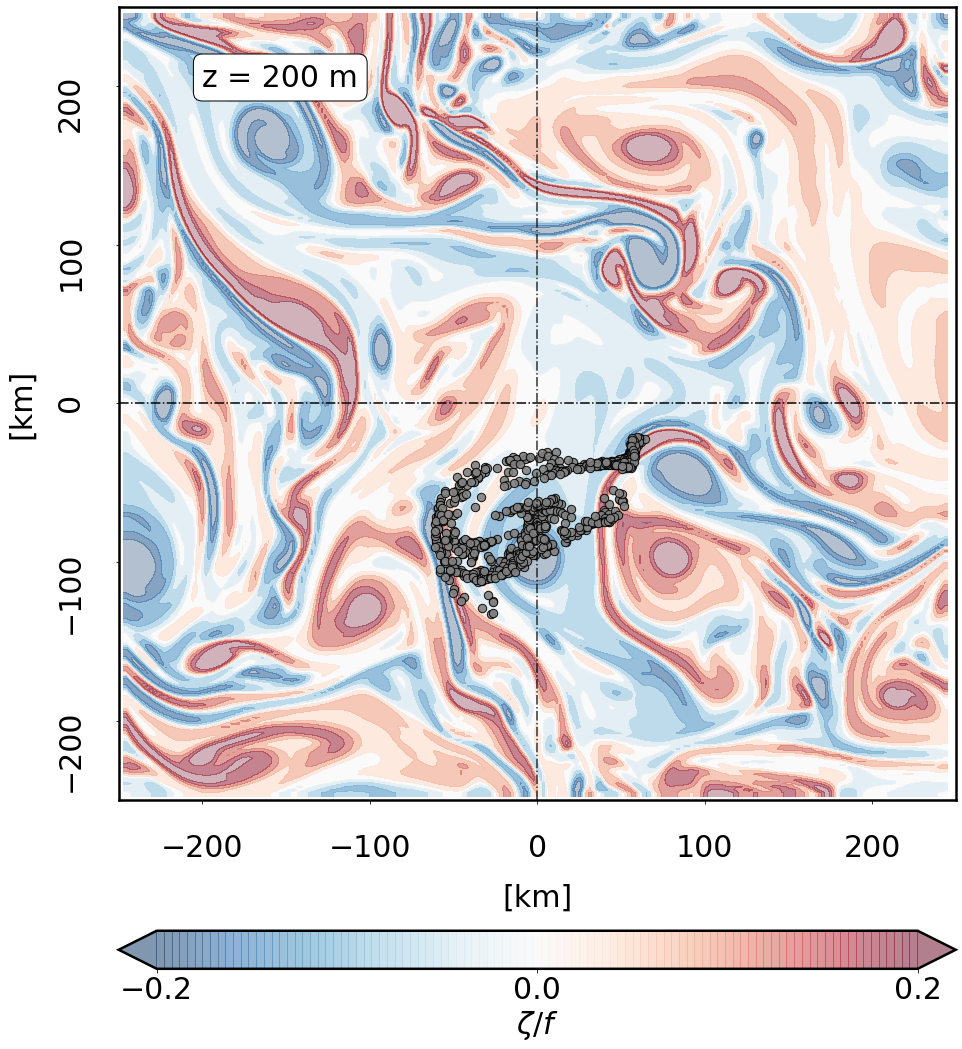

In [27]:
def short_proj():
    return np.dot(Axes3D.get_proj(ax), scale)

fig, ax = plt.subplots(1,1,figsize=(15,20))
cb = fig.colorbar(cf,  ax=[ax], location='bottom', pad=0.12,shrink=1,extend='both',ticks=[-0.2,0,0.2])
cb.set_label(r'$\zeta/f$',fontsize=labelsize)
cb.ax.tick_params(labelsize=labelsize)

dt = 80 + 5
figure_part_2D_dt(dt)

plt.savefig("snapshot_last_tstep_2D.png",dpi=200)

simulname is None
args (['apero', '[498,748,1449,1699,[1,100,1]]', '1286'],)
args[0] ['apero', '[498,748,1449,1699,[1,100,1]]', '1286']
len(args[0]) 3
time of simulation is: 1286
coord
loading /home/datawork-lops-osi/mlecorre/POLGYR/INIT/polgyr_grd.nc
loading /home/datawork-lops-osi/mlecorre/POLGYR/HIS/polgyr_his.01280.nc
get domain [498,748,1449,1699,[1,100,1]] [498,
coordmax
loading /home/datawork-lops-osi/mlecorre/POLGYR/INIT/polgyr_grd.nc
loading /home/datawork-lops-osi/mlecorre/POLGYR/HIS/polgyr_his.01280.nc
get domain [0,1e9,0,1e9,[1,1e9,1]] [0,1e
cst
read Cs_r in ncfile.Cs_r
dt
dt is read in  /home/datawork-lops-osi/mlecorre/POLGYR/HIS/polgyr_his.01280.nc
(250, 250)


<ipython-input-26-9fc43371cd01>:50: UserWarning: No contour levels were found within the data range.
  ax.contour(lon,lat,-topo,[-list_level[i]],colors='k',linewidths=1,linestyles='solid')


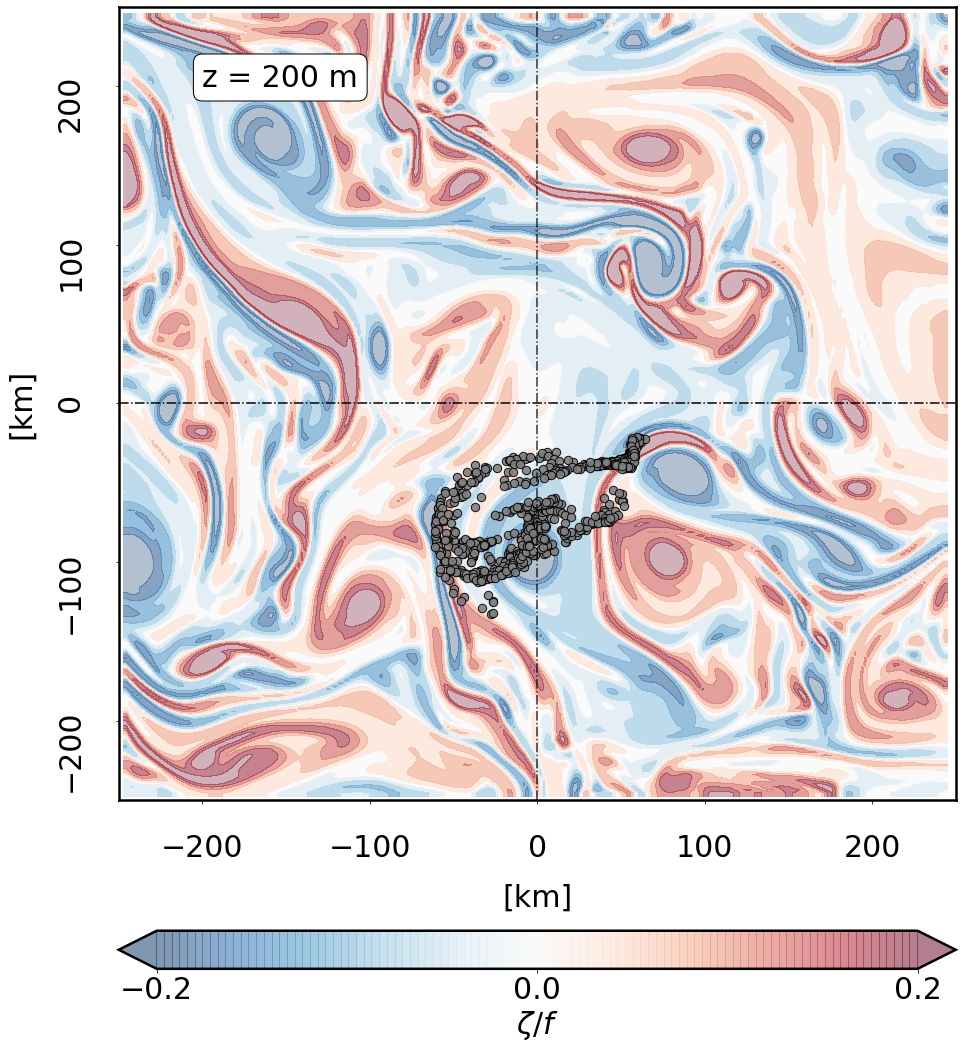

In [28]:

#fig, ax = plt.subplots(1,1,figsize=(15,15))
#ax = plt.axes(projection='3d')
#ax.get_proj=short_proj

fig, ax = plt.subplots(1,1,figsize=(15,20))
cb = fig.colorbar(cf,  ax=[ax], location='bottom', pad=0.12,shrink=1,extend='both',ticks=[-0.2,0,0.2])
cb.set_label(r'$\zeta/f$',fontsize=labelsize)
cb.ax.tick_params(labelsize=labelsize)

frames = 80 + 5 
ani = animation.FuncAnimation(fig, figure_part_2D_dt, frames=frames, interval=200)
ani.save('video_2D.gif', writer='pillow')

In [9]:
list_part_200 = []
list_part_200_dt = []

for dt_start in range(80):
    
    for i in range(0,nb_part-36,1):

        if pdepth[dt_start,i] > -200 and dt_start > 20 :
            list_part_200.append(i)
            list_part_200_dt.append(dt_start)


np.array(x_disp_level[-1,list_part_200]).shape

(10432,)

In [10]:
i*80

54640

In [11]:
len(list_part_200)

10432

In [12]:
y_disp_level.shape

(4, 720)

In [13]:
dx_pdf = 100

xband, yband = np.linspace(-400,400,dx_pdf+1), np.linspace(-400,400,dx_pdf+1)
binbox = (xband[1]-xband[0])*(yband[1]-yband[0])
X, Y = x_disp_level[-1,:], y_disp_level[-1,:]
H,xedges,yedges = np.histogram2d(X,Y,bins=[xband,yband])
#H=H.T
N = len(X)
jpdf = 1/(binbox*N)*H



In [14]:
jpdf.shape

(100, 100)

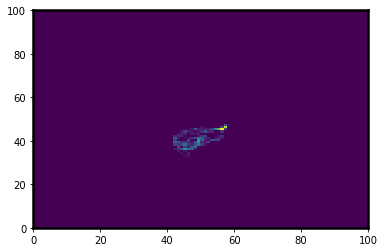

In [15]:
plt.pcolormesh(jpdf.T)

In [16]:

def time_step_update(imag,j,k, dt = .1):
    lplcn = imag[j,k-1] + imag[j-1,k] + imag[j,k+1] + imag[j+1,k] - 4*imag[j,k]
    return imag[j,k] + dt*lplcn

cur_imag = jpdf.copy()
for L in range(0,50):
    next_img = np.zeros(jpdf.shape)    
    for k in range(1, jpdf.shape[0]-1):
        for j in range(1, jpdf.shape[1]-1):
            next_img[j,k] = time_step_update(cur_imag,j,k)
    cur_imag = next_img       

jpdf_filtrer = cur_imag
#READ PDF

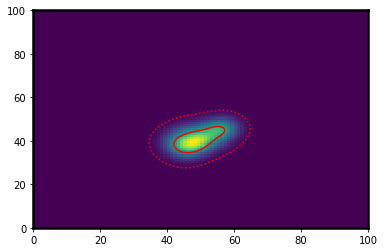

In [20]:
plt.pcolormesh(jpdf_filtrer.T)
levels_pred,fmt = add_contour_per(jpdf_filtrer,[99,50])
plt.contour(jpdf_filtrer.T,levels=levels_pred,colors=['red','red'],linestyles=['dotted','-'])

In [18]:
sys.path.append("/home2/datahome/tpicard/PhD_MOMOPAR/ANALYSE/")
from tools_analyse import *

simulname is None
args (['apero', '[492,742,1443,1693,[1,100,1]]', '1287'],)
args[0] ['apero', '[492,742,1443,1693,[1,100,1]]', '1287']
len(args[0]) 3
time of simulation is: 1287
coord
loading /home/datawork-lops-osi/mlecorre/POLGYR/INIT/polgyr_grd.nc
loading /home/datawork-lops-osi/mlecorre/POLGYR/HIS/polgyr_his.01280.nc
get domain [492,742,1443,1693,[1,100,1]] [492,
coordmax
loading /home/datawork-lops-osi/mlecorre/POLGYR/INIT/polgyr_grd.nc
loading /home/datawork-lops-osi/mlecorre/POLGYR/HIS/polgyr_his.01280.nc
get domain [0,1e9,0,1e9,[1,1e9,1]] [0,1e
cst
read Cs_r in ncfile.Cs_r
dt
dt is read in  /home/datawork-lops-osi/mlecorre/POLGYR/HIS/polgyr_his.01280.nc
(250, 250)


<ipython-input-37-0637d56d91c7>:44: UserWarning: No contour levels were found within the data range.
  ax.contour(lon,lat,-topo,[-list_level[i]],colors='k',linewidths=1,linestyles='solid')


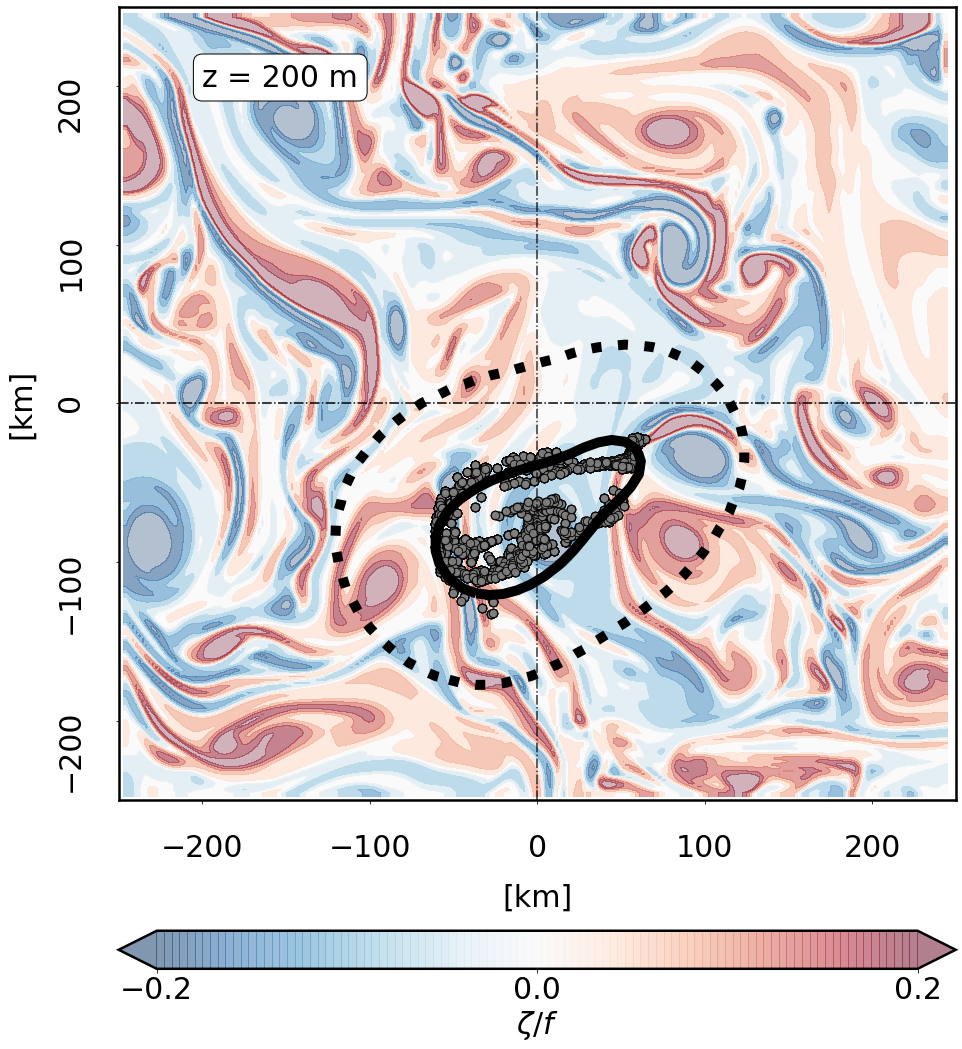

In [37]:
fig, ax = plt.subplots(1,1,figsize=(15,20))
cb = fig.colorbar(cf,  ax=[ax], location='bottom', pad=0.12,shrink=1,extend='both',ticks=[-0.2,0,0.2])
cb.set_label(r'$\zeta/f$',fontsize=labelsize)
cb.ax.tick_params(labelsize=labelsize)

dt = 83
plt.xticks(size=16)
plt.yticks(size=16,rotation=90)
ax.tick_params(axis='both',labelsize=labelsize,pad=30)

#plt.title('t = {0}'.format(i))
ax.set_xlim(-500, 500)
ax.set_ylim(-500,500)

ax.set_xlim(-250, 250)
ax.set_ylim(-250,250)

ax.set_xlabel('[km]',labelpad=labelpad,size=labelsize,rotation=0)
ax.set_ylabel('[km]',labelpad=labelpad,size=labelsize,rotation=90)

ax.plot(xline, xy, color='k',linestyle='-.',alpha=1)
ax.plot(xy, yline, color='k',linestyle='-.',alpha=0.8)
nb_part = pdepth.shape[1]
clear_output(wait=True)

i = -1
# A METTRE DANS LA BOUCLE
#for i in range(len(list_level)):
time_i = tend-number_of_exp-dt # Attention backward
level = list_level[i]
(lon,lat,vrt[:,:,i]) = plot_background_level_time(int(ic),int(jc),time_i,level)

nb_half_days = number_of_exp + dt
dt_start = number_of_exp + dt - 1
vrt_lim = 0.15
alpha_vrt=0.3



levels_vrt=np.linspace(-vrt_lim,vrt_lim,10)

cp  = ax.contourf(lon, lat, vrt[:,:,i],cmap = plt.cm.RdBu_r,alpha = alpha_vrt,vmin=-vrt_lim,vmax=vrt_lim,levels=levels_vrt,extend='min')
cp  = ax.contourf(lon, lat, vrt[:,:,i],cmap = plt.cm.RdBu_r,alpha = alpha_vrt,vmin=-vrt_lim,vmax=vrt_lim,levels=levels_vrt,extend='max')
ax.contour(lon,lat,-topo,[-list_level[i]],colors='k',linewidths=1,linestyles='solid')

ax.scatter(x_disp_level[-1,list_part_200],y_disp_level[-1,list_part_200], color='grey',s = size_part+60, marker='o',alpha =0.9,edgecolor='k')

lon_jpdf = np.linspace(-400,400,100)
lat_jpdf = np.linspace(-400,400,100)
#plt.pcolormesh(lon_jpdf,lat_jpdf,jpdf.T,alpha=0.2)
plt.contour(lon_jpdf,lat_jpdf,jpdf_filtrer.T,levels=levels_pred,colors=['k','k'],linestyles=['dotted','-'],linewidths=10)

    
props = dict(boxstyle='round', facecolor='white', alpha=1)
text = "z = 200 m".format(dt//2)
ax.text(-200,200,text,size=30,bbox=props)
    
plt.savefig("snapshot_contour_and_scatter.png",dpi=200)